In [1]:
import sys
import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

np.set_printoptions(threshold=1000)
pd.set_option('display.max_rows', 100)

pp = pprint.PrettyPrinter()

/cvmfs/sft.cern.ch/lcg/releases/matplotlib/1.5.1-763af/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#es = Elasticsearch([{'host': 'hcc-metrics.unl.edu', 'port': 9200}])
username = 'cms'
password = 'B3A96-D0g_PkkPz5'
es = Elasticsearch([{'host': 'es-cms.cern.ch', 'port': 9203, 'http_auth': username+':'+password}], use_ssl=True,verify_certs=True,ca_certs="ca-bundle.trust.crt")

In [3]:
indices = es.cat.indices(index="cms-*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

In [4]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["cms-*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'cms-', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if until <= diff.days < days + until:
            filtered.append(i.rstrip())
    return filtered

In [80]:
# Change second argument to use a different time range for ES queries
no_of_days = 10   # how many days to consider
last_day = 0   # how many days was the last day to consider
# example: no_of_days = 20, last_day = 10 means: use 20 days, up to 10 days ago
ind = time_filter(indices, 10, 0)
ind = ','.join(ind)
print ind

cms-2017-04-04,cms-2017-04-05,cms-2017-04-06,cms-2017-04-07,cms-2017-04-08,cms-2017-04-09,cms-2017-04-10,cms-2017-04-11,cms-2017-04-12,cms-2017-04-13


In [81]:
def tasktype2(row):
    task = row['task'].lower()
    ttype = row['tasktype'].lower()

    if ttype == 'analysis':
        tt = 'Analysis'
    elif 'cleanupunmerged' in ttype:
        tt = 'Cleanup'
    elif 'logcollect' in ttype:
        tt = 'LogCollect'
    elif ttype == 'repack':
        tt = 'Repack'
    elif ttype.startswith('skim'):
        tt = 'Skim'
    elif 'harvest' in ttype:
        tt = 'Harvesting'
    elif 'merge' in ttype:
        tt = 'Merge'
    elif ttype.startswith('express'):
        tt = 'Express'
    elif ttype == 'alcaskim':
        tt = 'Alcaskim'
    elif 'gensim' in ttype:
        tt = 'GENSIM'
    elif ttype == 'montecarlofromgen':
        tt = 'GENSIM'
    elif ttype == 'gen':
        tt = 'GEN'
    elif ttype == 'reco':
        tt = 'RECO'
    elif ttype == 'dataprocessing':
        tt = 'RECO'
    elif ttype.startswith("reco"):
        tt = 'RECO'
    elif ttype.endswith("_0"):
        tt = 'DIGI'
    elif ttype.endswith("_1"):
        tt = 'DIGIRECO'
    elif ttype.startswith("digi"):
        tt = 'DIGI'
    elif ttype == 'steponeproc':
        tt = 'DIGI'
    elif ttype == 'steptwoproc':
        tt = 'DIGIRECO'
    elif ttype == 'stepthreeproc':
        tt = 'DIGIRECOMINIAOD'
    elif 'miniaod' in ttype:
        tt = 'MINIAOD'
    elif ttype == 'production':
        tt = 'GENSIM'
    elif 'hlt' in ttype:
        tt = 'RECO'
    elif "validation" in task:
        tt = "Validation"
    elif "relval" in task:
        tt = "RelVal"
    elif "fastsim" in task:
        tt = "FastSim"
    elif "premix" in task:
        tt = "Premix"
    elif "minbias" in task:
        tt = "MinBias"
    else:
        tt = "Other"

    return tt

These variables are used:
* **RequestCpus**: number of cores used by the job
* **CpuTimeHr**: CPU time used by the job (system+user), not the one reported by cmsRun (hours). **It must be > 0**
* **WallClockHr**: wall-clock time used by the job (hours), not just on cmsRun
* **CoreHr**: wall-clock time used by the job (see above) times the number of cores (hours). **It must be > 0**
* **CpuEff**: CPU efficiency of the whole job (not just cmsRun) (%)
* **Type**: type of job (production or analysis)
* **Status**: job status (completed, running, idle, removed, held). **It must be 'completed'**
* **TaskType**: it is either analysis, or it is derived from *WMAgent_TaskType* (production, merge, digireco, repack, reco, cleanup, logcollect, miniaod, express, dataprocessing, gensim, etc.)
* **Site**: site assigned to the job
* **Workflow**: workflow name. Derived either from *CRAB_Workflow* or from *WMAgent_RequestName*
* **Kevents**: thousands of events in the job (often not reported by all versions of CMSSW). Derived from *ChirpCMSSWEvents*. **It must be > 0**
* **InputGB**: amount of data read by job (GB). **It must exist** and it exists only from CMSSW_8_0_0. Derived from *ChirpCMSSWReadBytes*
* **OutputGB**: amount of data written by job (GB). It seems to exist if and only if InputGB exists. Derived from *ChirpCMSSWWriteBytes*
* **CPUModel**: name of the CPU. It is either taken from *ChirpCMSSWCPUModels* or from *MachineAttrCPUModel0*. It has two synonymous fields, CPUModelName and Processor
* **WMAgent_SubTaskName**: subtask name for production jobs, used as "task identifier"
* **CpuTimePerEvent**: inverse of **CpuEventRate**, which is defined if *CpuTimeHr* > 0 as *ChirpCMSSWEvents* / *CpuTimeHr* * 3600
* **TimePerEvent**: inverse of **Eventrate**, which is defined if *CoreHr* >0 as *ChirpCMSSWEvents* / *CoreHr* * 3600
* **MemoryMB**: RSS used by the job (MB) (from HTCondor's ResidentSetSize_RAW)

In [82]:
# Query for production jobs

s1 = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "filter": [
                        {
                            "range": {
                                "CpuTimeHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CoreHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CMSSWWallHrs": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "KEvents": {"gt": 0.}
                            }
                        },
                        {
                            "exists": {
                                "field": "InputGB"
                            }
                        },
                        {
                            "exists": {
                                "field": "ExitCode"
                            }
                        },
                        {
                            "match": {
                                "Status": "completed"
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ttypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "cputype": {
                            "terms": {
                                "field": "CPUModel",
                                "size": 1000
                            },
                            "aggs": {
                                "wf": {
                                    "terms": {
                                        "field": "WMAgent_SubTaskName",
                                        "size": 100000
                                    },
                                    "aggs": {
                                        "type": {
                                            "terms": {
                                                "field": "Type",
                                                "size": 10
                                            },
                                            "aggs": {
                                                "exitcode": {
                                                    "terms": {
                                                        "field": "ExitCode",
                                                        "size": 1000
                                                    },
                                                    "aggs": {
                                                        "1": {
                                                            "extended_stats": {
                                                                "field": "CpuTimePerEvent"
                                                            }
                                                        },
                                                        "2": {
                                                            "extended_stats": {
                                                                "field": "TimePerEvent"
                                                            }
                                                        },
                                                        "3": {
                                                            "stats": {
                                                                "field": "CpuTimeHr"
                                                            }
                                                        },
                                                        "4": {
                                                            "stats": {
                                                                "field": "CoreHr"
                                                            }
                                                        },
                                                        "6": {
                                                            "avg": {
                                                                "field": "RequestCpus"
                                                            }
                                                        },
                                                        "7": {
                                                            "stats": {
                                                                "field": "ChirpCMSSWEvents"
                                                            }
                                                        },
                                                        "8": {
                                                            "avg": {
                                                                "field": "CpuEff"
                                                            }
                                                        },
                                                        "9": {
                                                            "avg": {
                                                                "script": "doc['MemoryMB'].value / doc['RequestCpus'].value",   # average RAM per core
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "10": {
                                                            "stats": {
                                                                "field": "InputGB"   # average input data per job and total input data per task
                                                            }
                                                        },
                                                        "11": {
                                                            "stats": {
                                                                "field": "OutputGB"   # average input data per job and total input data per task
                                                            }
                                                        },
                                                        "12": {
                                                            "avg": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['InputGB'].value / doc['KEvents'].value : 0",   # average input data (MB) per event 
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "13": {
                                                            "avg": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['OutputGB'].value / doc['KEvents'].value : 0",   # average output data (MB) per event
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "14": {
                                                            "avg": {
                                                                "script": "doc['CMSSWWallHrs'].value > 0 ? doc['InputGB'].value / (doc['CMSSWWallHrs'].value * doc['RequestCpus'].value * 3.6) : 0",   # average input data rate per thread
                                                                "lang": "expression"
                                                            },
                                                        },
                                                        "15": {
                                                            "avg": {
                                                                "script": "doc['CMSSWWallHrs'].value > 0 ? doc['OutputGB'].value / (doc['CMSSWWallHrs'].value * doc['RequestCpus'].value * 3.6) : 0",   # average output data rate per thread
                                                                "lang": "expression"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res1 = es.search(index=ind, body=s1, request_timeout=12000)

In [83]:
# Query for analysis jobs

s2 = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "filter": [
                        {
                            "range": {
                                "CpuTimeHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CoreHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CMSSWWallHrs": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "KEvents": {"gt": 0.}
                            }
                        },
                        {
                            "exists": {
                                "field": "InputGB"
                            }
                        },
                        {
                            "exists": {
                                "field": "ExitCode"
                            }
                        },
                        {
                            "match": {
                                "Status": "completed"
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ttypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "cputype": {
                            "terms": {
                                "field": "CPUModel",
                                "size": 1000
                            },
                            "aggs": {
                                "wf": {
                                    "terms": {
                                        "field": "CRAB_Workflow",
                                        "size": 100000
                                    },
                                    "aggs": {
                                        "type": {
                                            "terms": {
                                                "field": "Type",
                                                "size": 10
                                            },
                                            "aggs": {
                                                "exitcode": {
                                                    "terms": {
                                                        "field": "ExitCode",
                                                        "size": 1000
                                                    },
                                                    "aggs": {
                                                        "1": {
                                                            "extended_stats": {
                                                                "field": "CpuTimePerEvent"
                                                            }
                                                        },
                                                        "2": {
                                                            "extended_stats": {
                                                                "field": "TimePerEvent"
                                                            }
                                                        },
                                                        "3": {
                                                            "stats": {
                                                                "field": "CpuTimeHr"
                                                            }
                                                        },
                                                        "4": {
                                                            "stats": {
                                                                "field": "CoreHr"
                                                            }
                                                        },
                                                        "6": {
                                                            "avg": {
                                                                "field": "RequestCpus"
                                                            }
                                                        },
                                                        "7": {
                                                            "stats": {
                                                                "field": "ChirpCMSSWEvents"
                                                            }
                                                        },
                                                        "8": {
                                                            "avg": {
                                                                "field": "CpuEff"
                                                            }
                                                        },
                                                        "9": {
                                                            "avg": {
                                                                "script": "doc['MemoryMB'].value / doc['RequestCpus'].value",   # average RAM per core
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "10": {
                                                            "stats": {
                                                                "field": "InputGB"   # average input data per job and total input data per task
                                                            }
                                                        },
                                                        "11": {
                                                            "stats": {
                                                                "field": "OutputGB"   # average input data per job and total input data per task
                                                            }
                                                        },
                                                        "12": {
                                                            "avg": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['InputGB'].value / doc['KEvents'].value : 0",   # average input data (MB) per event 
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "13": {
                                                            "avg": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['OutputGB'].value / doc['KEvents'].value : 0",   # average output data (MB) per event
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "14": {
                                                            "avg": {
                                                                "script": "doc['CMSSWWallHrs'].value > 0 ? doc['InputGB'].value / (doc['CMSSWWallHrs'].value * doc['RequestCpus'].value * 3.6) : 0",   # average input data rate per thread
                                                                "lang": "expression"
                                                            },
                                                        },
                                                        "15": {
                                                            "avg": {
                                                                "script": "doc['CMSSWWallHrs'].value > 0 ? doc['OutputGB'].value / (doc['CMSSWWallHrs'].value * doc['RequestCpus'].value * 3.6) : 0",   # average output data rate per thread
                                                                "lang": "expression"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res2 = es.search(index=ind, body=s2, request_timeout=12000)

In [84]:
output_file = 'task_cms_30dy_1.csv'

In [85]:
names = ['task', 'tasktype', 'site', 'cputype', 'type', 'exitcode', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg', 'wallevt_rms',
         'cpu', 'cpu_avg', 'wc', 'wc_avg', 'cores', 'evts', 'evts_avg', 'eff', 'ramcore', 'input', 'input_avg',
         'output', 'output_avg', 'inevt', 'outevt', 'inrate', 'outrate']

with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(names)
    for res in (res1, res2):
        buckets1 = res['aggregations']['ttypes']['buckets']
        for b1 in buckets1:
            ttype = b1['key']
            buckets2 = b1['site']['buckets']
            for b2 in buckets2:
                site = b2['key']
                buckets3 = b2['cputype']['buckets']
                for b3 in buckets3:
                    cputype = b3['key']
                    buckets4 = b3['wf']['buckets']
                    for b4 in buckets4:
                        wf = b4['key']
                        buckets5 = b4['type']['buckets']
                        for b5 in buckets5:
                            typ = b5['key']
                            buckets6 = b5['exitcode']['buckets']
                            for b6 in buckets6:
                                exitcode = b6['key']
                                writer.writerow([
                                    wf,
                                    ttype,
                                    site,
                                    cputype,
                                    typ,
                                    exitcode,
                                    b6['1']['count'],           # no. of jobs in task (technically, in the bucket)
                                    b6['1']['avg'],             # average of CPU time per event
                                    b6['1']['std_deviation'],   # standard deviation of CPU time per event
                                    b6['2']['avg'],             # average of wall-clock time times cores per event
                                    b6['2']['std_deviation'],   # standard deviation of wall-clock time times cores per event
                                    b6['3']['sum'] * 3600.,     # total CPU time (seconds)
                                    b6['3']['avg'] * 3600.,     # average CPU time (seconds)
                                    b6['4']['sum'] * 3600.,     # total wall-clock time times cores (seconds)
                                    b6['4']['avg'] * 3600.,     # average wall-clock time times cores (seconds)
                                    b6['6']['value'],           # cores
                                    b6['7']['sum'],             # events in task
                                    b6['7']['avg'],             # average events in job
                                    b6['8']['value'],           # CPU efficiency (%)
                                    b6['9']['value'],           # Memory usage per core (MB)
                                    b6['10']['sum'] * 1000.,    # Input data per task (MB)
                                    b6['10']['avg'] * 1000.,    # average input data per job (MB)
                                    b6['11']['sum'] * 1000.,    # input data per task (MB)
                                    b6['11']['avg'] * 1000.,    # average output data per job (MB)
                                    b6['12']['value'],          # Output data per event (MB)
                                    b6['13']['value'],          # Output data per event (MB)
                                    b6['14']['value'],          # input data rate (MB/sec)
                                    b6['15']['value']           # output data rate (MB/sec)
                                    ])

In [91]:
input_file = 'task_cms_30dy_1.csv'

In [92]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, low_memory=False)

In [93]:
df['jobtype'] = df.apply(lambda row: tasktype2(row), axis=1)

In [94]:
df[:5]

,task,tasktype,site,cputype,type,exitcode,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,...,ramcore,input,input_avg,output,output_avg,inevt,outevt,inrate,outrate,jobtype
0,/pdmvserv_egm-phaseispring17gs-00014_00004_v0_...,production,t1_uk_ral,intel(r) xeon(r) cpu e5-2640 v3 @ 2.60ghz,production,0,15464,475.370055,148.223289,600.501030,...,525.943666,1.452499e+06,93.927795,82153.754015,5.312581,5.525311,0.312515,0.009168,0.000565,GENSIM
1,/pdmvserv_egm-phaseispring17gs-00014_00004_v0_...,production,t1_uk_ral,intel(r) xeon(r) cpu e5-2640 v3 @ 2.60ghz,production,40,2,1236.535714,343.464286,1366.404762,...,1007.749023,1.967506e+02,98.375296,16.197206,8.098603,7.976258,0.643594,0.005263,0.000453,GENSIM
2,/pdmvserv_egm-phaseispring17gs-00012_00004_v0_...,production,t1_uk_ral,intel(r) xeon(r) cpu e5-2640 v3 @ 2.60ghz,production,0,10300,453.477594,143.193247,572.536468,...,534.531435,2.489558e+06,241.704629,67397.997700,6.543495,14.218625,0.384914,0.028119,0.000737,GENSIM
3,/pdmvserv_egm-phaseispring17gs-00012_00004_v0_...,production,t1_uk_ral,intel(r) xeon(r) cpu e5-2640 v3 @ 2.60ghz,production,40,1,582.333333,0.000000,700.000000,...,1021.722656,5.344372e+01,53.443719,8.642841,8.642841,4.453643,0.720237,0.006464,0.001045,GENSIM
4,/pdmvserv_egm-phaseispring17gs-00013_00004_v0_...,production,t1_uk_ral,intel(r) xeon(r) cpu e5-2640 v3 @ 2.60ghz,production,0,19,19.223064,2.472259,20.156902,...,214.571083,1.851652e+04,974.553581,409.876351,21.572440,2.298475,0.050878,0.123194,0.002613,GENSIM


## Preliminary data exploration

In [95]:
grouped = df.groupby(['jobtype'], as_index=False)
a = grouped.agg({'task': 'nunique', # ok!
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'evts': 'sum',           # ok!
                 'inrate': 'mean'
                })
a.sort_values('wc', ascending=False)

,jobtype,inrate,cpuevt_avg,task,wc,cores,wallevt_avg,evts,njobs
3,GENSIM,0.124560,341.082507,70,1.238979e+10,4.003735,478.756896,4.248356e+09,859676
1,DIGI,2.195278,55.623836,233,8.309420e+09,4.048967,368.135997,1.469271e+08,317478
0,Analysis,0.885593,24.267363,370,3.251481e+09,1.347487,45.593510,1.919075e+09,277338
9,RECO,0.307965,41.618668,300,2.400874e+09,3.987783,78.087552,1.179885e+08,229744
5,Merge,12.639369,0.224684,1240,9.810177e+07,1.000000,1.860122,5.300554e+08,80629
4,MINIAOD,0.264508,2.023183,77,8.250913e+07,3.496540,3.923879,3.595092e+07,19712
2,FastSim,2.291570,16.216531,38,5.087128e+07,1.000000,22.260198,3.212064e+06,4680
7,Other,0.375529,3.175307,94,3.331554e+07,4.000000,8.444744,9.391586e+06,3057
8,Premix,2.049406,46.515840,2,1.106465e+07,4.000000,57.089984,2.000000e+05,2000
6,MinBias,0.261661,363.844071,4,8.548220e+06,4.000000,1343.173282,5.920000e+05,2192


## Average number  of jobs in task

737.523786408


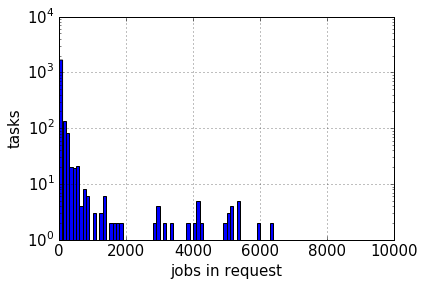

In [96]:
plt.rcParams.update({'font.size': 15})
grouped = df[df.type == 'production'].groupby(['task'], as_index=False)
a = grouped['njobs'].sum()
print np.mean(a['njobs'])
fig = a['njobs'].hist(bins=100, log=True, range=[0., 10000.])
plt.xlabel('jobs in request')
plt.ylabel('tasks')

## Average number of events in task

10000.0


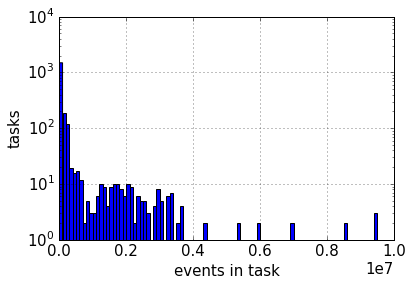

In [97]:
grouped = df[df.type == 'production'].groupby(['task'], as_index=False)
a = grouped['evts'].sum()
print np.median(a['evts'])
fig = a['evts'].hist(bins=100, log=True, range=(0., 1e7))
plt.xlabel('events in task')
plt.ylabel('tasks')

## Average CPU efficiency of tasks

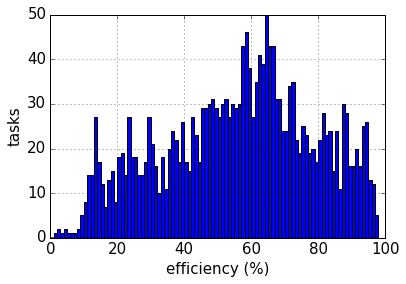

In [98]:
grouped = df[df.type == 'production'].groupby(['task'], as_index=False)
a = grouped['eff'].mean()
fig = a['eff'].hist(bins=100, log=False, range=(0, 100))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency (%)')
plt.ylabel('tasks')

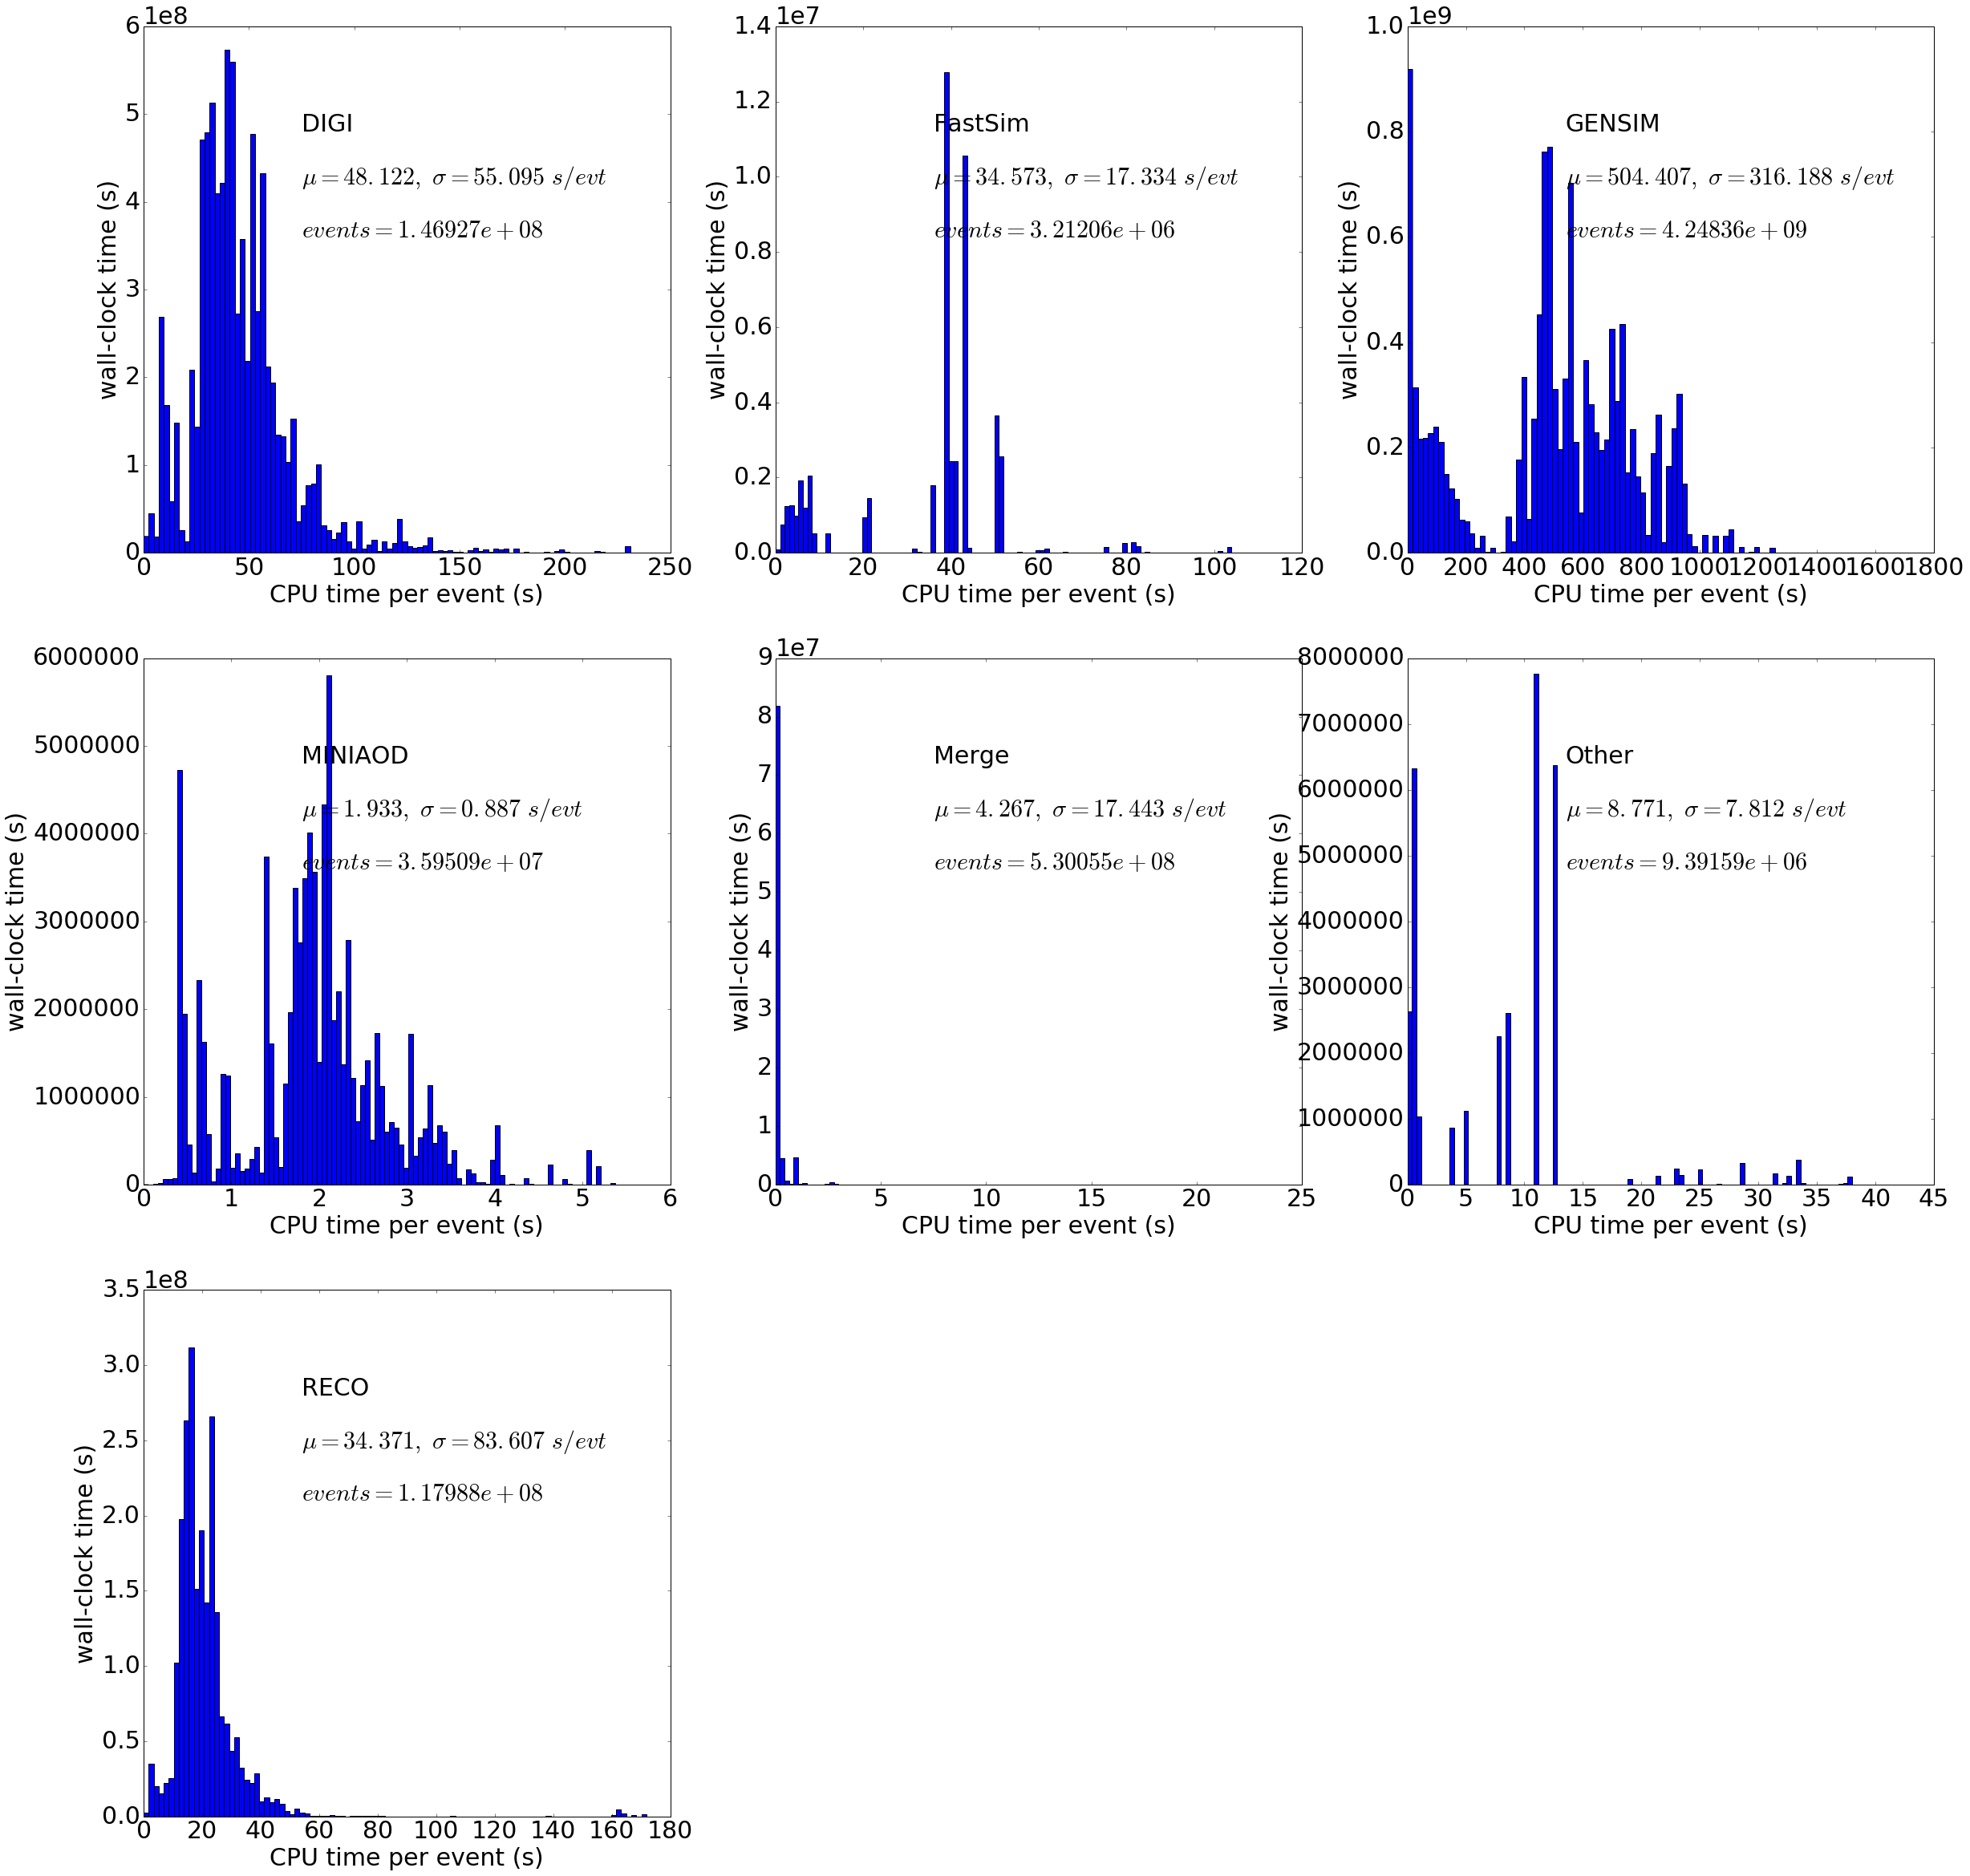

In [99]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df[df.type == 'production']['wc'].sum()
i = 1

grouped = df[df.type == 'production'].groupby(['jobtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.001 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., mean + min(mean, std) * 4.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.3), t_y(.8), p)
        plt.text(t_x(.3), t_y(.7), stats)
        plt.text(t_x(.3), t_y(.6), stats2)
    i += 1

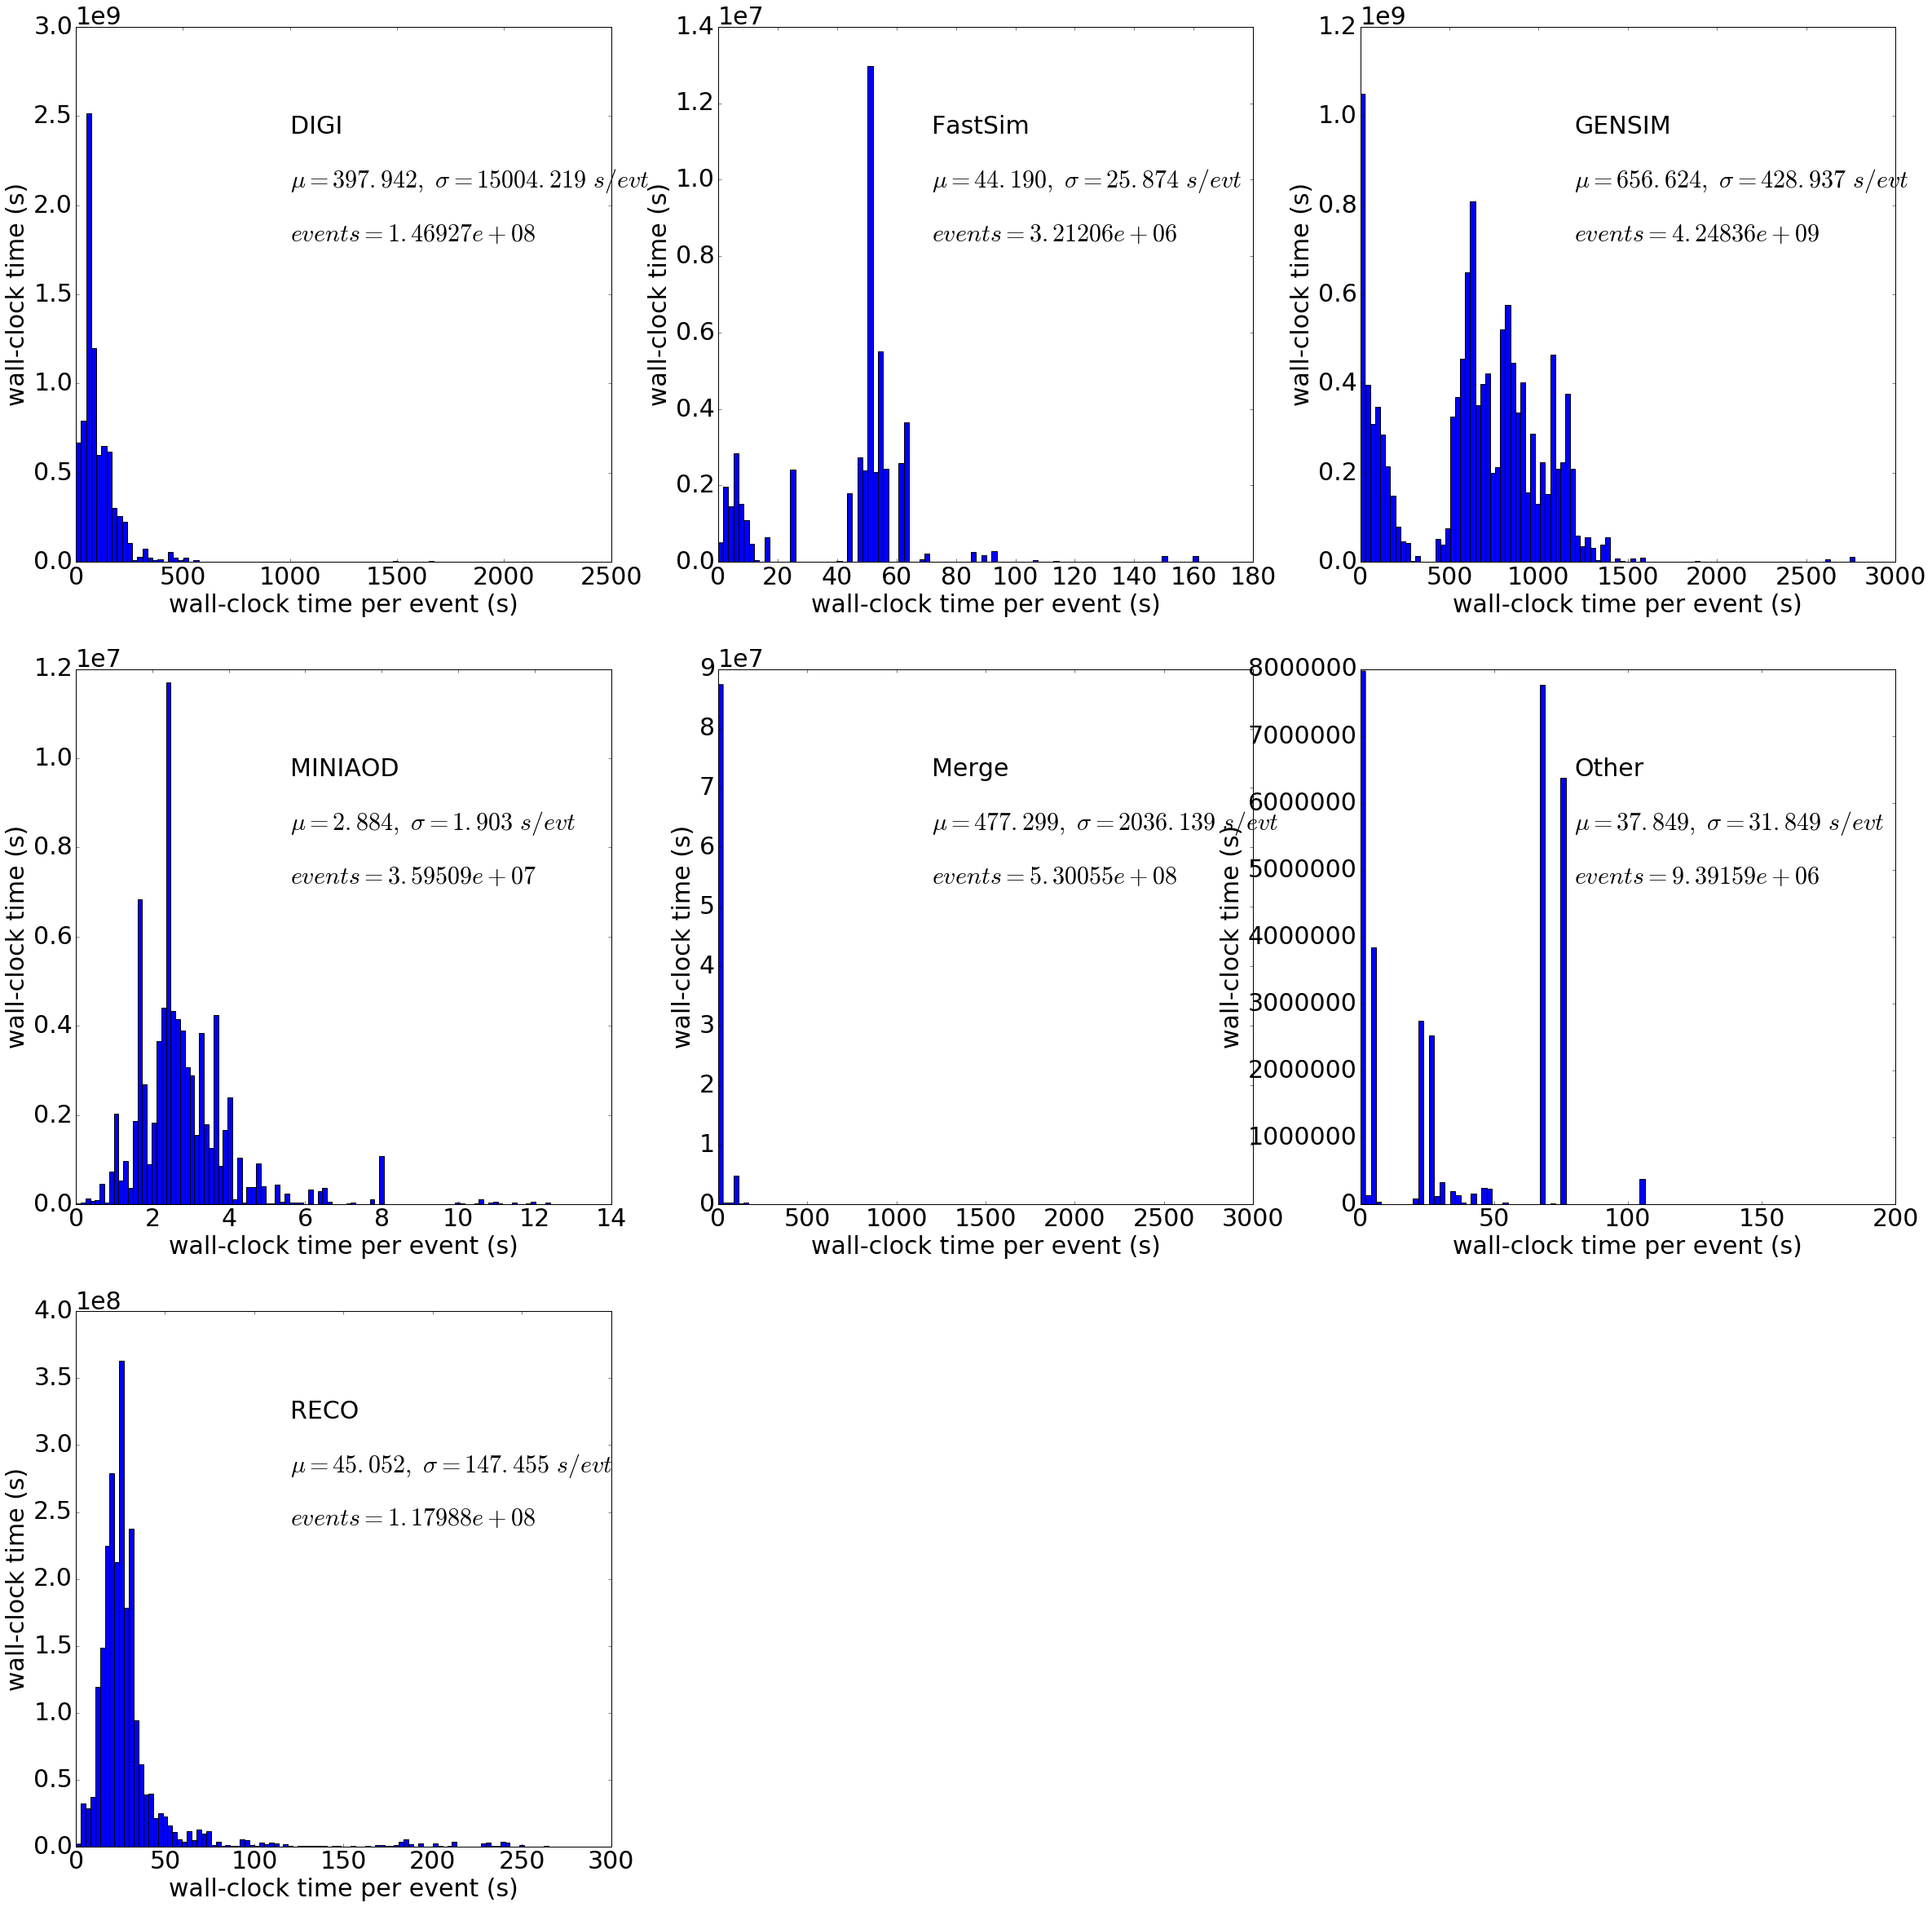

In [100]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
log_scale = False
wc_tot = df[df.type == 'production']['wc'].sum()
i = 1

grouped = df[df.type == 'production'].groupby(['jobtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.001 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., mean + min(mean, std) * 5.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

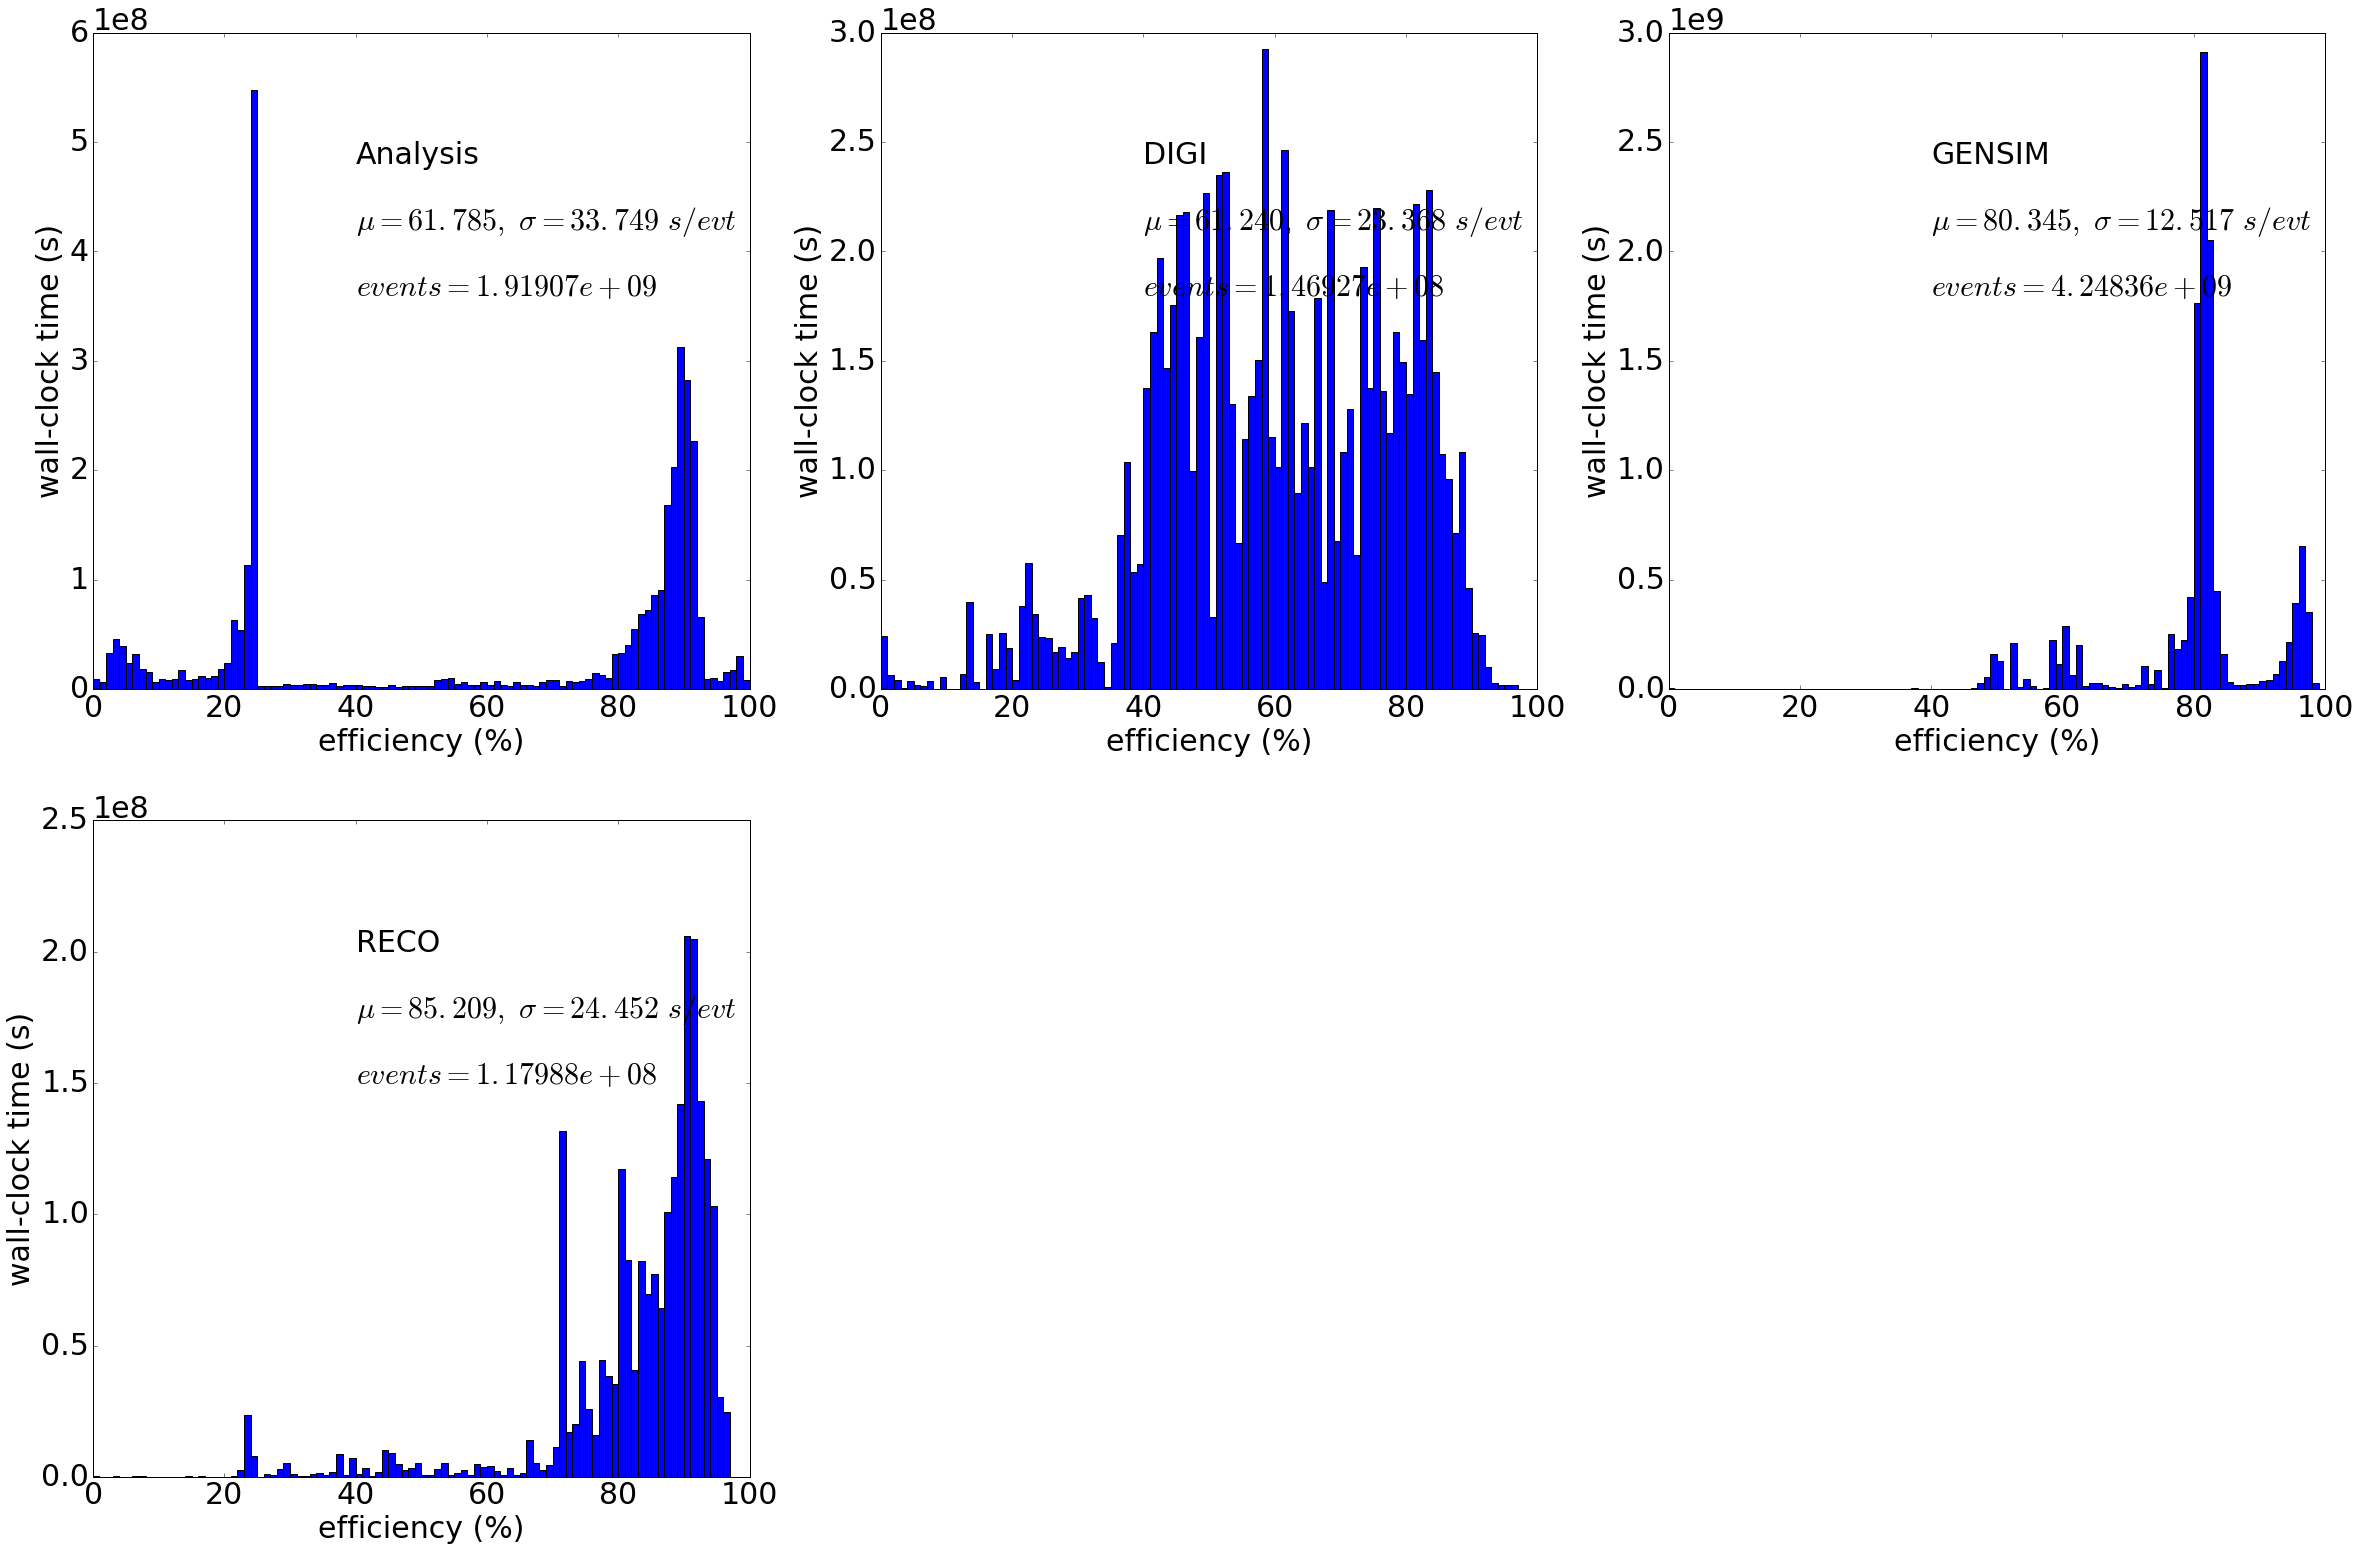

In [101]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'eff'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['jobtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.006 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., 100.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('efficiency (%)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

## Inspect a random task of a given type

In [102]:
ptype = 'DIGI'

# Find JEDI task with given parameters
tot_evts = dict()
grouped = df.groupby(['jobtype', 'task'], as_index=False)
for (p, j), g in grouped:
    if (p != ptype): continue
    tot_evts[j] = g['evts'].sum()

biggest_tasks = sorted(tot_evts, key=tot_evts.get, reverse=True)
a = biggest_tasks[:5]
random_task = np.random.choice(a, 1)
print random_task

[ '/pdmvserv_task_egm-phaseispring17wmlhegs-00003__v1_t_170407_201504_3668/egm-phaseispring17wmlhegs-00003_0']


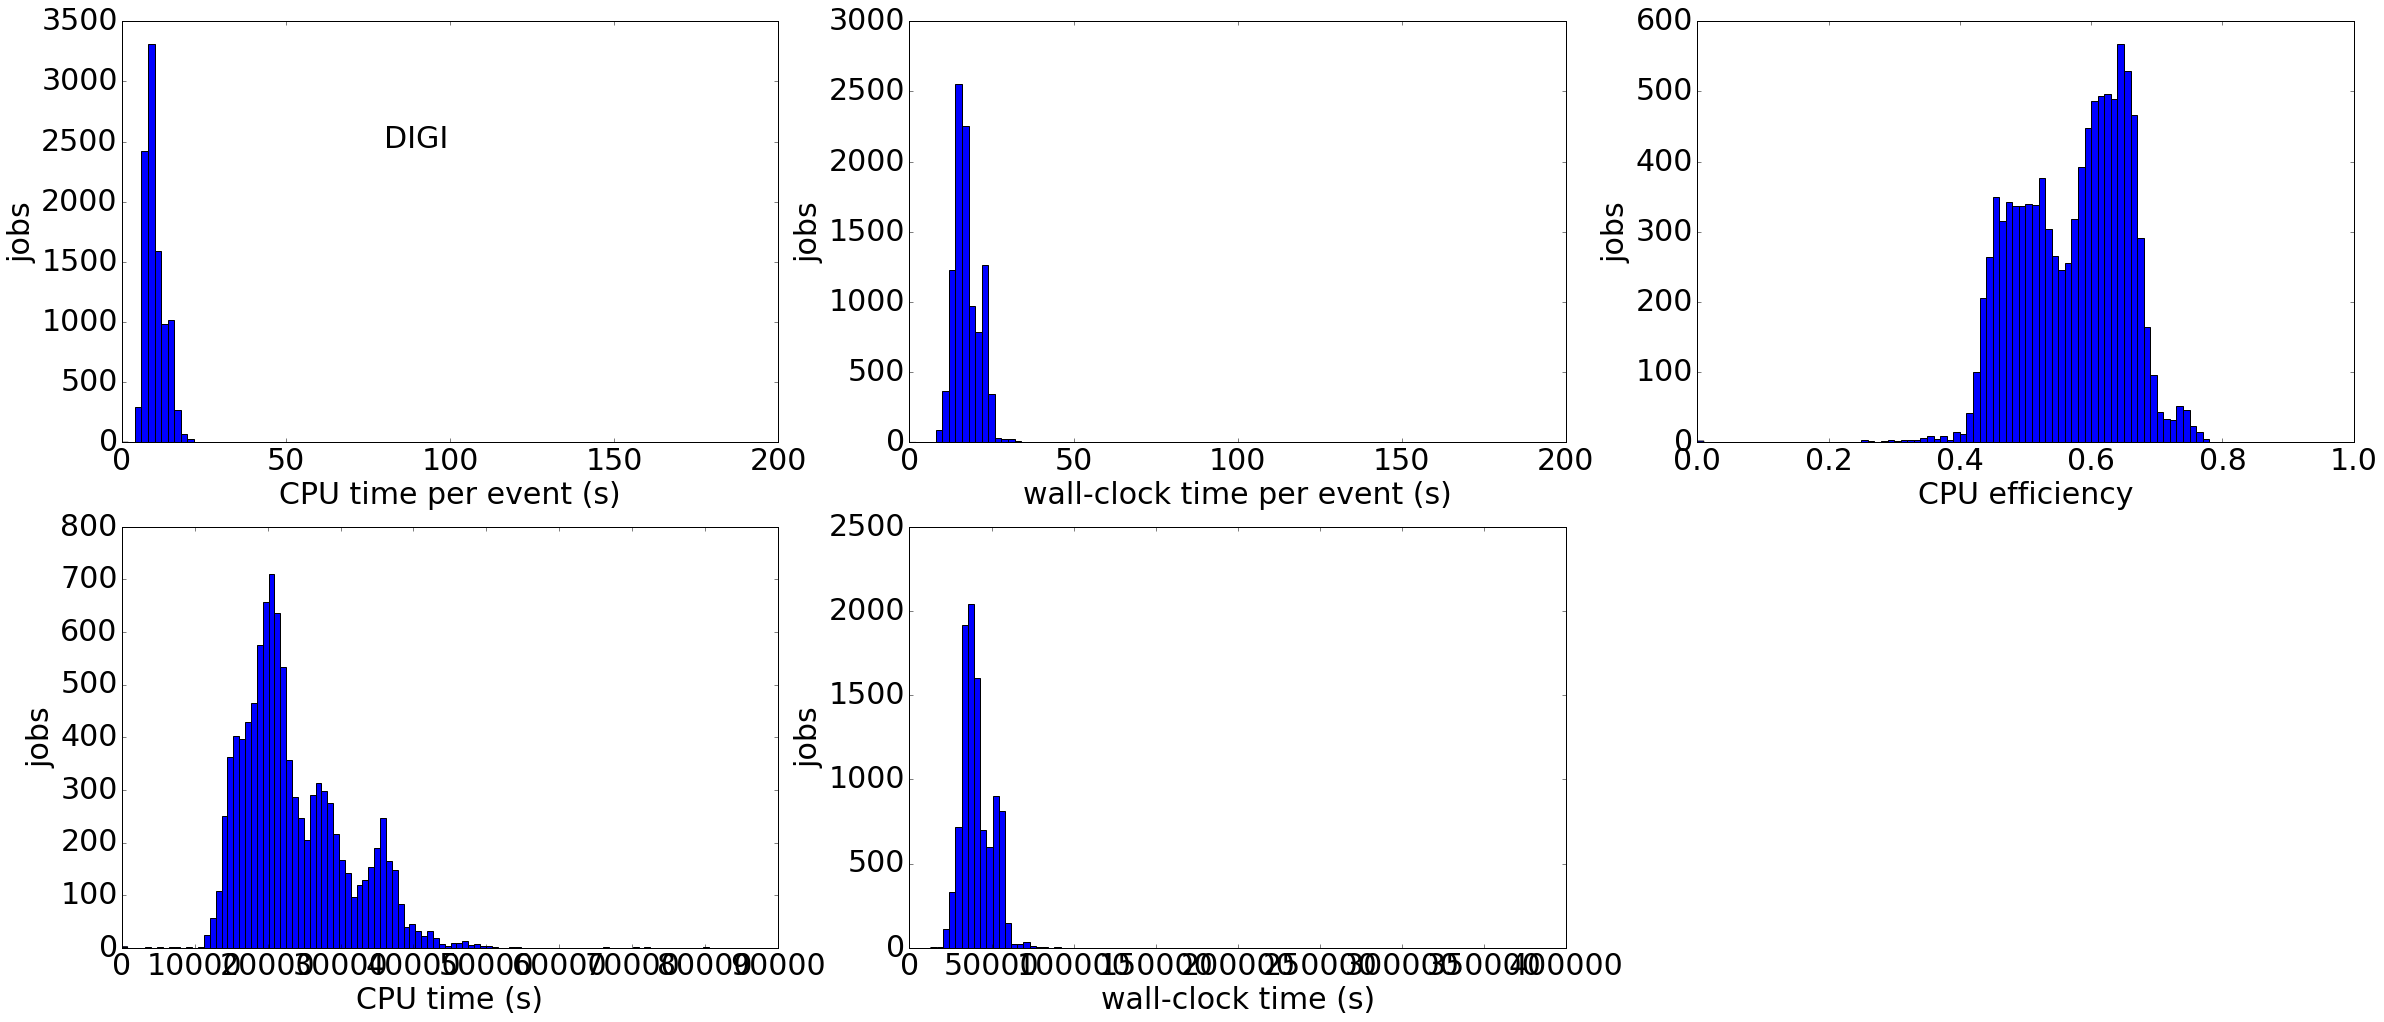

In [103]:
fig2 = plt.figure(figsize=(40,80))
plt.rcParams.update({'font.size': 30})
i = 1
for t in random_task:
    s = {
        "size": 10000,
        "_source": ["CpuTimeHr", "CoreHr", "RequestCpus", "KEvents", "CpuEff"],
        "query": {
            "filtered": {
                "filter": {
                    "bool": {
                        "must": [
                            { "match": { "WMAgent_SubTaskName": t}},
                            { "range": {"KEvents": {"ge": 0.0001}}},
                            { "range": {"CoreHr": {"gte": 0.0010}}},
                            { "match": {"Status": "completed"}}
                        ]
                    }
                }
            }
        }
    }
    res = es.search(index=ind, body=s, request_timeout=300)
    cputimes = list()
    wctimes = list()
    effs = list()
    cpus = list()
    wcs = list()
    for h in res['hits']['hits']:
        vars = h['_source']
        cpuevt = vars['CpuTimeHr'] / vars['KEvents'] * 3.6
        wcevt = vars['CoreHr'] / vars['KEvents'] * 3.6
        eff = vars['CpuEff'] / 100.
        cpu = vars['CpuTimeHr'] * 3600.
        wc = vars['CoreHr'] * 3600.
        cputimes.append(cpuevt)
        wctimes.append(wcevt)
        effs.append(eff)
        cpus.append(cpu)
        wcs.append(wc)
    sp = plt.subplot(9, 3, i)
    plt.hist(cputimes, bins=100, range=[0., 200.])
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('jobs')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(0.4), t_y(.7), ptype)
#    stats = r'$req=%s$' % (t)
#    plt.text(t_x(.4), t_y(.6), stats)
    sp = plt.subplot(9, 3, i+1)
    plt.hist(wctimes, bins=100, range=[0., 200.])
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+2)
    plt.hist(effs, bins=100, range=[0., 1.])
    plt.xlabel('CPU efficiency')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+3)
    plt.hist(cpus, bins=100, range=None)
    plt.xlabel('CPU time (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+4)
    plt.hist(wcs, bins=100, range=None)
    plt.xlabel('wall-clock time (s)')
    plt.ylabel('jobs')
    i += 5

In [104]:
df['cputype'].unique()

array(['intel(r) xeon(r) cpu e5-2640 v3 @ 2.60ghz',
       'intel(r) xeon(r) cpu e5-2650 v2 @ 2.60ghz',
       'intel(r) xeon(r) cpu e5-2630 v3 @ 2.40ghz',
       'intel(r) xeon(r) cpu e5-2660 0 @ 2.20ghz',
       'intel(r) xeon(r) cpu e5-2670 0 @ 2.60ghz',
       'intel(r) xeon(r) cpu x5650 @ 2.67ghz',
       'qemu virtual cpu version (cpu64-rhel6)',
       'intel(r) xeon(r) cpu e5645 @ 2.40ghz',
       'intel(r) xeon(r) cpu e5-2640 v4 @ 2.40ghz',
       'intel(r) xeon(r) cpu x5647 @ 2.93ghz',
       'intel(r) xeon(r) cpu e5620 @ 2.40ghz',
       'intel(r) xeon(r) cpu e5640 @ 2.67ghz',
       'intel(r) xeon(r) cpu e5410 @ 2.33ghz',
       'intel(r) xeon(r) cpu e5520 @ 2.27ghz',
       'intel(r) xeon(r) cpu e5-2609 v2 @ 2.50ghz',
       'intel(r) xeon(r) cpu e5335 @ 2.00ghz',
       'intel(r) xeon(r) cpu e5310 @ 1.60ghz',
       'intel(r) xeon(r) cpu e5-2650 v4 @ 2.20ghz',
       'intel(r) xeon(r) cpu e5-2650 v3 @ 2.30ghz',
       'intel(r) xeon(r) cpu e5-2660 v2 @ 2.20ghz',
       'am